# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #9
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, April 7th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [2]:
import pymc3 as pm
from pymc3 import Model, Normal, Bernoulli, find_MAP, sample, traceplot
import warnings
warnings.filterwarnings('ignore')
import theano.tensor as t
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline

## Question 1. Separate the Bayesian Irises

The goal of this problem is to introduce you to the idea of classification 
using Bayesian inferences. 

You are given the famous *Fisher flower Iris data set*
which is a  multivariate data set introduced by Sir Ronald Fisher (1936) as an example of discriminant analysis.
The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on the combination of these four features, you will build a model to predict
the species. 

For this problem only consider two classes: **virginica** and **not-virginica**. 

The iris data can be obtained [here](iris.txt).

Lets $(X, Y )$ be our dataset, where $X=\{\vec{x}_1, \ldots \vec{x}_n\}$ and $\vec{x}_i$ is a 5D vector corresponding to an offset 1 and
the four components explained above. $Y \in \{0,1\}$ are the scalar 
labels of a class. In other words  
the species labels are your $Y$ data (virginica = 0 and virginica=1), and the four features, petal length
and width, sepal length and width, along with the offset, are your $X$ data. 

The goal is to train a classifier, that will predict an unknown class label $\hat{y}$ from a new data point $x$. 

Consider the following glm (logistic model) for the probability of a class:

$$ p(y) = \frac{1}{1+e^{-x^T \beta}} $$

(or $logit(p) = x^T \beta$ in more traditional glm form)

where $\beta$ is a 5D parameter to learn. 

Then given $p$ at a particular data point $x$, we can use a bernoulli likelihood to get 1's and 0's. This should be enough for you to set up your model in pymc3. (Other Hints: also use theano.tensor.exp when you define the inerse logit to go from $\beta$ to $p$, and you might want to set up $p$ as a deterministic explicitly so that pymc3 does the work of giving you the trace).

Use a 60-40 stratified (preserving class membership) split of the dataset into a training set and a test set. ( See the docs for scikit-learn's `train_test_split`).

## Part A: Sampling

1. Choose a prior for $\beta \sim N(0, \sigma^2 I) $ and write down the formula for the normalized posterior $p(\beta| Y,X)$. Since we dont care about regularization here, just use the mostly uninformative value $\sigma = 10$.
2. Find the MAP and mean estimate for the posterior on the training set.
3. Implement a  sampler to sample from this posterior of $\beta$.   Generate samples of $\beta$ and plot the sequence of $\beta$'s  and histograms for each $\beta$ component.
4. Use both the MAP and MEAN estimate of $\beta$, and the posterior distribution of $\beta$, to generate a set of probabilities and a set of posterior distributions respectively, for each data point $x$ in the training set. Plot the posterior against the MAP and MEAN estimate for 2 or 3 of your data points, preferably those with MAP estimates closer to 0.5.

**Solutions:**

With a normal prior, our Bayesian model for logistic regression is as follows:
\begin{align}
y_j &\sim Ber(\sigma(\beta^Tx_j)), \quad j = 1, \ldots, N\\
\beta &\sim \mathcal{N}(0, 10I)
\end{align}
where $\sigma$ is the sigmoid function
$$
\sigma(x) = \frac{1}{1 + e^{-x}} = \frac{e^{x}}{e^{x} + 1}.
$$

In this problem we're exploring the difference between using point estimates from the posterior distribution (like MAP or posterior mean), the entire posterior distribution and the posterior predictive distribution to inform our decisions and predictions after the inference step.

In Part A, we contrast the effects of using different point estimates from the posterior distribution for computing the probability, $p(y_j = 1 | \beta, x_j)$. For this, we will obtain samples from the posterior $p(\beta |\{y_j\}, \{x_j\} )$. 

In Part B, we contrast the effect of using point estimates from the posterior distribution for computing the probability, $p(y_j = 1 | \beta, x_j)$ against that of using the posterior predictive, $p(y^{new}_j = 1 | \{y^{old}_j\})$. For this, we will obtain samples from the posterior $p(\beta |\{y_j\}, \{x_j\} )$. 


### 1. Sampling
Given our model, the posterior is
$$
p(\beta | \{y_j\}_j, \{x_j\}_j) = \frac{\prod_j p(y_j | \beta, x_j) p(\beta)}{p(\{y_j\}_j)} = \frac{\prod_j Ber(\sigma(\beta^Tx_j))\mathcal{N}(0, 10I)}{\int \prod_j  Ber(\sigma(\beta^Tx_j))\mathcal{N}(0, 10I) d\beta}
$$
Note that while we can compute, using the expression above, the MAP and mean of the posterior distribution, there is not an easy closed form expression for the posterior predictive and sampling from this posterior by hand will also be difficult.

#### Preping the Data

In [118]:
#Read data
df = pd.read_csv('iris.txt')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [119]:
#For converting classification 'Iris-virginica' to 1 and the rest to 0
d = {'Iris-setosa': 0, 'Iris-versicolor': 0, 'Iris-virginica':1}
#Feature dimensions, with bias
D = df.shape[1]
#Number of data points
N = df.shape[0]
#Number of samples
n_samples = 5000

#Train, test split
x_train, x_test, y_train, y_test = train_test_split(np.append(df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values, np.ones((df.shape[0], 1)), axis=1), 
                                                    df['class'].map(d).values, 
                                                    test_size=0.4)

#### Setting Up the Model in Pymc3

In [120]:
#Sigmoid function
def invlogit(x):
    return t.exp(x) / (1 + t.exp(x))

#Input
x = t._shared(x_train)
#Target
y = t._shared(y_train)

#Instantiate pymc3 model
logistic_model = Model()

#Set up model
with logistic_model:
    #Prior
    betas = Normal('betas', mu=0, tau=1 / 100, shape=(D, ))
    
    #p(y_j=1 | beta, x_j)
    p = invlogit(x.dot(betas))
    
    #Likelihood
    y_obs = Bernoulli('y_obs', p=p, observed=y)
    

#### Sampling from the Model

In [ ]:
#Sampling from model
with logistic_model:
    #Find posterior mode estimate of beta, start sampling from MAP
    MAP = find_MAP()
    trace = sample(n_samples, init=None, start=MAP)

#### Sampling Diagnostics: Trace and Autocorrelation Plots

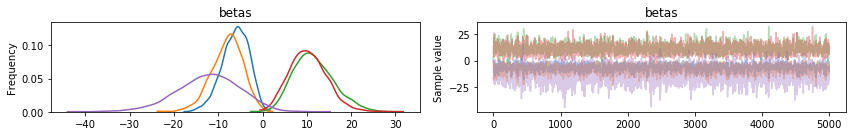

In [123]:
#Traceplots
traceplot(trace)
plt.show()

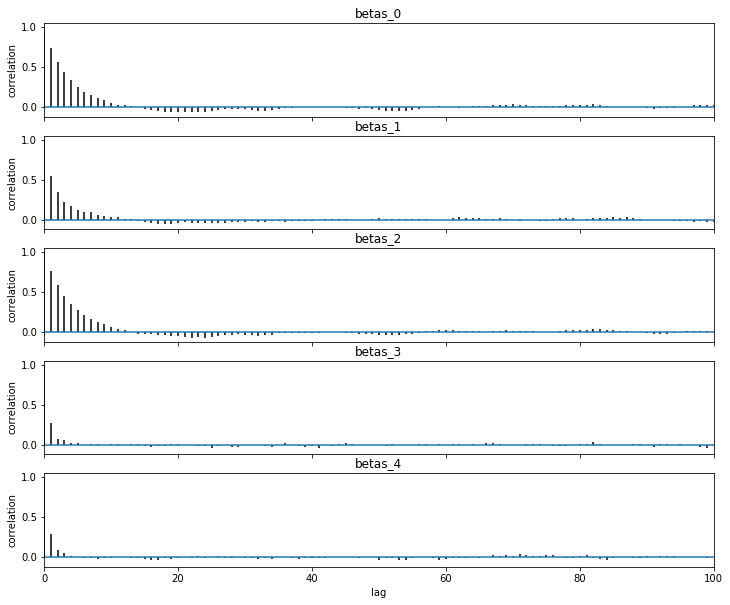

In [124]:
#Autocorrelation plots
pm.autocorrplot(trace)
plt.show()

From the diagnostic plots, it looks like our sampler has mixed. Now, from these samples of $\beta$, we want to compute the posterior mode (MAP) and posterior mean.

#### Point Estimates

In [125]:
#Sigmoid function
def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))

#Dot product of x and beta
beta_coef = lambda x, beta: x.dot(beta)

#Posterior mean of beta
beta_mean = trace['betas'].mean(axis=0)

#p(y | beta, x) using posterior mean
p_y_mean = sigmoid(beta_coef(x_train, beta_mean))
#p(y | beta, x) using posterior mode
p_y_MAP = sigmoid(beta_coef(x_train, MAP['betas']))
#p(y | beta, x) using all posterior samples, that is, we have 5000 p's for
#each training x
p_y_post = sigmoid(beta_coef(x_train, trace['betas'].T))

#Find the training x with p(y | beta_MAP, x) closest to 0.5
indx = np.argmin(np.abs(p_y_MAP - 0.5))

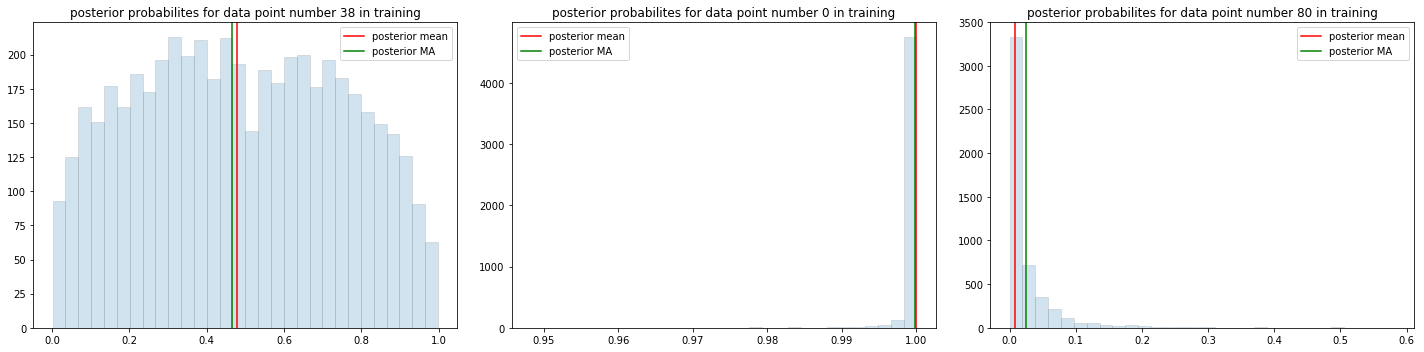

In [127]:
#Plot the various p(y | beta, x) for three training data points
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

#Plot for training x with p(y | beta_MAP, x) closest to 0.5
ax[0].hist(p_y_post[indx, :], bins=30, edgecolor='gray', linewidth='1', alpha=0.2)
ax[0].axvline(x=p_y_mean[indx], color='red', label='posterior mean')
ax[0].axvline(x=p_y_MAP[indx], color='green', label='posterior MA')
ax[0].set_title('posterior probabilites for data point number ' + str(indx) + ' in training')
ax[0].legend(loc='best')

#Plot for traning #10
ax[1].hist(p_y_post[10, :], bins=30, edgecolor='gray', linewidth='1', alpha=0.2)
ax[1].axvline(x=p_y_mean[10], color='red', label='posterior mean')
ax[1].axvline(x=p_y_MAP[10], color='green', label='posterior MA')
ax[1].set_title('posterior probabilites for data point number ' + str(0) + ' in training')
ax[1].legend(loc='best')

#Plot for traning #80
ax[2].hist(p_y_post[80, :], bins=30, edgecolor='gray', linewidth='1', alpha=0.2)
ax[2].axvline(x=p_y_mean[80], color='red', label='posterior mean')
ax[2].axvline(x=p_y_MAP[80], color='green', label='posterior MA')
ax[2].set_title('posterior probabilites for data point number ' + str(80) + ' in training')
ax[2].legend(loc='best')
plt.tight_layout()
plt.show()

### Conclusions:

Immediately, we observe two things:
1. the posterior mean and the posterior mode (MAP) estimates of the model parameters can be quite different
2. point estimates alone do not capture all the important features in the posterior distribution. In particular, they fail to give us a sense of how "certain" these estimates are or how much confidence we can place in them. For example, from the distribution of $p$'s arising from the posterior samples of $\beta$ for data point \#38, we see that we have less reason to be confident in our estimate of  $p(y_{38} = 1 | x_{38}, \beta)$; where as, in contrast, we have more reason to be confident in our estimate of $p(y_{0} = 1 | x_{0}, \beta)$.

Note that our ultimate task is to classify a data point as either 0 (not Iris-virginica) or 1 (Iris-virginica). Computing a probability $p(y_{j} = 1 | x_{j}, \beta)$ alone does not determine this classification. What we need is a method of producing a binary classification given an estimate $p(y_{j} = 1 | x_{j}, \beta)$. Then, we need to investigate the effect of our choices of estimtates of $\beta$ on the quality of our classification (for example, by looking at misclassifcation rates). This is precisely what we will study in Part B.

---

Now that we have both point estimate(s) and a posterior distribution on the probability of a data point being virginica, we can use these to make predictions on both the training set and test set.

**There are two ways to make these predictions, given an estimate of $p(y=1 \vert x)$ **: 

(A) You can sample from the Bernoulli likelihood at the data point $x$ to decide if that particular data points classification $y(x)$ should be a 1 or a 0.

(B) Or you could do the intuitive "machine-learning-decision-theoretic" (MLDT) thing, where you assign a data  point $x$ a classification 1 if $p(y=1 \vert x) > 0.5$.

**And there are multiple ways in which you can do these probability estimates at a sample $x$**:

(A) You could just use the MAP value, ($p_{MAP}$), or the posterior mean ($p_{MEAN}$)

(B) You can see what fraction of your posterior samples have values above 0.5 (ie you are calculating 1-cdf(0.5)) on the posterior ($p_{CDF}$))

(C) Both these above methods miss the combined smearing of the posterior and sampling distributions. In other words they dont sample from the posterior predictive. If we draw a large number of samples from the posterior predictive distribution at a data point $x$, the fraction of 1s will give an estimate for the probability to use, $p_{PP}$, which is different from the MAP estimate, or the CDF estimate.

## Part B: Playing with Probabilities

1. Plot the distribution of $p_{MEAN}$, $p_{CDF}$, and $p_{PP}$ over all the data points in the training set. How are these different?
2. Plot the posterior-predictive distribution of the misclassification rate with respect to the true class identities $y(x)$ of the data points $x$ (in other words you are plotting a histogram with the misclassification rate for the $n_{trace}$ posterior-predictive samples) on the training set.
3. Make the same plot from the posterior, rather than the posterior predictive, by using the MLDT defined above. Overlay this plot on the previous one. That is, for every posterior sample, consider whether the data point ought to be classified as a 1 or 0 from the $p>0.5 \implies y=1$ decision theoretic prespective. Compare with your previous diagram. Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution? 
4. Is the classification at the true training data points (you can think of this as a bitstring '100101...' 90 characters long) represented in the posterior predictive trace? If so, how many times? Is it the most frequent string in the traces? Explain your conclusions.
5. Repeat 2 and 3 for the test set, i.e. make predictions. Describe and interpret the widths of the distributions?
 
**Solutions:**

In Part B, we study the problem of how to produce a binary classification from a estimate of $p(y_j=1 | x_j)$. 

### I. Training Data

In [128]:
#Sample from the posterior predictive
posterior_pred = pm.sample_ppc(trace, model=logistic_model)

100%|██████████| 5000/5000 [00:14<00:00, 333.34it/s]


In [154]:
#P_pp: the fraction of posterior predictives that are 1
p_y_pp = posterior_pred['y_obs'].mean(axis=0)

#Count the number of p's from the posterior samples that are over 0.5
p_y_post_thresh = p_y_post[:, :]
p_y_post_thresh[p_y_post_thresh > 0.5] = 1
p_y_post_thresh[p_y_post_thresh <= 0.5] = 0

#P_cdf
p_y_cdf = p_y_post_thresh.mean(axis=1)

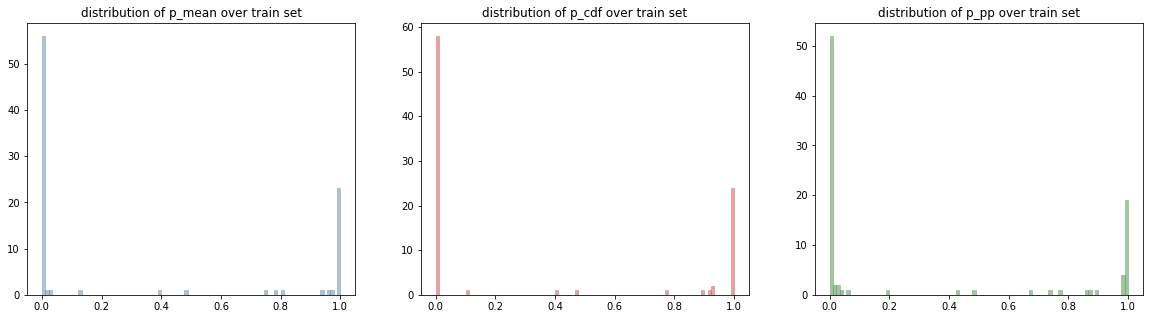

In [155]:
#Distribution of p(y | x, beta) over the training set
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(p_y_mean, bins=90, edgecolor='gray', linewidth='1', alpha=0.4)
ax[0].set_title('distribution of p_mean over train set')

ax[1].hist(p_y_cdf, bins=90, color='red', edgecolor='gray', linewidth='1', alpha=0.4)
ax[1].set_title('distribution of p_cdf over train set')

ax[2].hist(p_y_pp, bins=90, color='green', edgecolor='gray', linewidth='1', alpha=0.4)
ax[2].set_title('distribution of p_pp over train set')
plt.show()

**Analysis:** In the above, we see that the distribution of $p_{PP}$ is the widest of the three. That is, for many more data points, the fraction of posterior predictive classifications of 1 is close to 0.5, whereas there are far fewer data points with $p_{cdf}$ and $p_{mean}$ close to 0.5. In other words, $p_{PP}$ expresses "uncertainty" regarding its classification for many more data points. 

In [156]:
#Posterior predictive misclassification rates over training set
post_pred_misclass = np.abs(y_train - posterior_pred['y_obs']).mean(axis=0)
#Posterior misclassification rates over training set
post_misclass = np.abs(y_train - p_y_post_thresh.T).mean(axis=0)

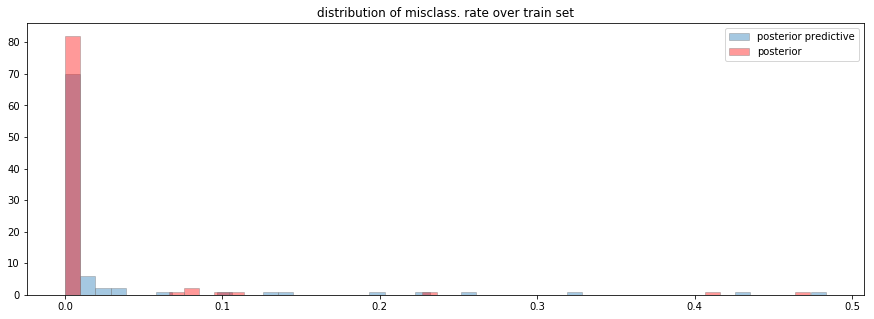

In [157]:
#Distribution of misclassification rates over the training set
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

#Posterior predictve misclassification
ax.hist(post_pred_misclass, bins=50, edgecolor='gray', linewidth='1', alpha=0.4, label='posterior predictive')
#Posterior misclassification
ax.hist(post_misclass, bins=50, color='red', edgecolor='gray', linewidth='1', alpha=0.4, label='posterior')

ax.set_title('distribution of misclass. rate over train set')
ax.legend(loc='best')
plt.show()

**Analysis:** We see from the above that the distribution of the posterior predictive misclassification rates is wider than that of the posterior. Note that this is not to say that using the posterior predictive to classify will lead to a higher error rate in the end! Afterall, in generating the above plot, we have not really produced a single classification for each training data point (i.e. we haven't really produced a final classification of the training set). Rather, the above plot shows the different levels of certainty or conservativeness between the two distributions. In particular, the posterior classifications  are more confident in the sense that we treat a probability of $p(y=1 | \beta, x) = 0.51$ the same as $p(y=1 | \beta, x) = 0.99$ - they both produce a classification of 1. On the otherhand, when we simulate sampling from the posterior predictive, a probability $p(y=1 | \beta, x) = 0.51$ would, conservatively, only yield a classification of 1 half of the time. The wider misclassification rate of the posterior predictive distribution reflects the aforementioned  conservativeness.

### II. Testing Data

We perform the same analysis on the testing set.

In [163]:
p_y_mean_test = sigmoid(beta_coef(x_test, beta_mean))

p_y_post_test = sigmoid(beta_coef(x_test, trace['betas'].T))

post_pred_test = np.random.binomial(1, p_y_post_test)

p_y_pp = post_pred_test.mean(axis=1)

p_y_post_thresh = p_y_post_test[:, :]
p_y_post_thresh[p_y_post_thresh > 0.5] = 1
p_y_post_thresh[p_y_post_thresh <= 0.5] = 0

p_y_cdf = p_y_post_thresh.mean(axis=1)

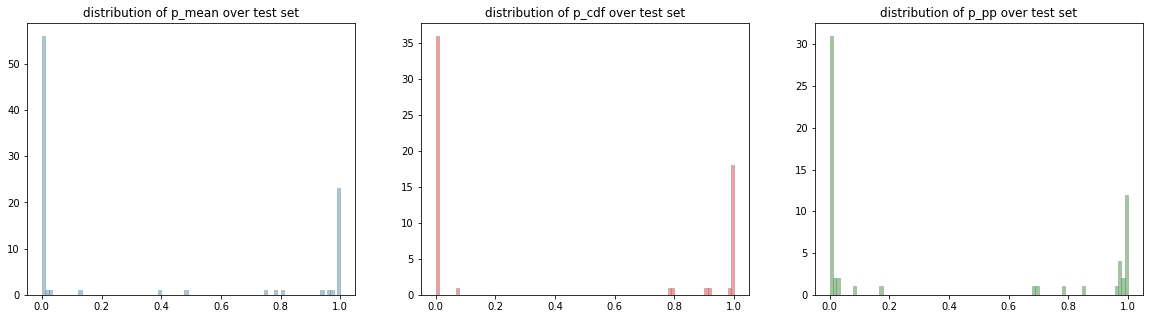

In [164]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(p_y_mean, bins=90, edgecolor='gray', linewidth='1', alpha=0.4)
ax[0].set_title('distribution of p_mean over test set')

ax[1].hist(p_y_cdf, bins=90, color='red', edgecolor='gray', linewidth='1', alpha=0.4)
ax[1].set_title('distribution of p_cdf over test set')

ax[2].hist(p_y_pp, bins=90, color='green', edgecolor='gray', linewidth='1', alpha=0.4)
ax[2].set_title('distribution of p_pp over test set')
plt.show()

**Analysis:** Again, in the above, we see that the distribution of $p_{PP}$ is the widest of the three. That is, $p_{PP}$ expresses "uncertainty" regarding its classification for many more data points. 

In [165]:
post_pred_misclass_test= np.abs(y_test - post_pred_test.T).mean(axis=0)
post_misclass_test = np.abs(y_test - p_y_post_thresh.T).mean(axis=0)

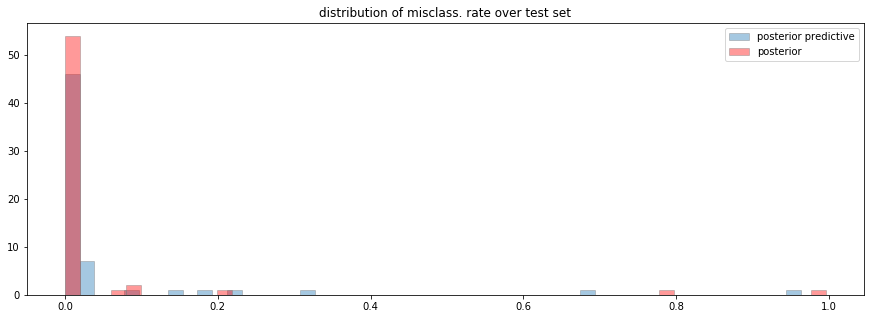

In [166]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.hist(post_pred_misclass_test, bins=50, edgecolor='gray', linewidth='1', alpha=0.4, label='posterior predictive')
ax.hist(post_misclass_test, bins=50, color='red', edgecolor='gray', linewidth='1', alpha=0.4, label='posterior')
ax.set_title('distribution of misclass. rate over test set')
ax.legend(loc='best')
plt.show()

**Analysis:** Agian, we see from the above that the distribution of the posterior predictive misclassification rates is wider than that of the posterior. Again, we note that this is not to say that using the posterior predictive to classify will lead to a higher error rate in the end! 

**What is the point of this HW:** In this Homework we've explored several ways to estimate $p(y | x)$ - using posterior point estimates and computing $p(y | x)$ as $p(y | \beta, x)$, using the posterior predictive to compute $p(y | x)$ directly - we have also explored several ways to produce a binary classification from a probability $p(y | x)$ or $p(y | \beta, x)$. 

What we have discovered is that some method produce more "conservative" classifcations than others. But what we have not explored is which method gives us better results in the absolute sense, minimal classification error. In general, it is not the case that one can say using the posterior mean yields less error than MAP, or using posterior point estimates yields more error than posterior predictive. The point of the assignment is to be aware of the existence of multiple choices one can make at every juncture, thus illustrating the need for principled exploration of one's choices (or the careful justification of one's choices).